In [24]:
import pandas as pd
from mp_api.client import MPRester
import csv
import os
import pickle
import multiprocessing as multi
from tqdm.auto import tqdm
from pymatgen.core import Composition
from htvs_module.htvs_mods import e_above_hull_calculator

<font size="8">Formation Energy<font> 

<font size="6">Prepare training and prediction datasets for ML<font> 

In [5]:
elements_list = ["Li", "Na", "K"]
filename = '../Data/train_data_Ef_Eg.csv'

In [6]:
with MPRester("8Gz6ZHndNpXJ19RAl8KJMiiaxIB9k10j") as mpr:
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['material_id','formula_pretty', 'composition', 'E_f', 'E_g'])

        for elem in elements_list:
            docs = mpr.materials.summary.search(
                elements=[elem],
                fields=["material_id","formula_pretty","formation_energy_per_atom","composition", "band_gap"]
    )
            mpids = [doc.material_id for doc in docs]
            formulas = [doc.formula_pretty for doc in docs]
            fomation_energys = [doc.formation_energy_per_atom for doc in docs]
            compositions = [doc.composition for doc in docs]
            band_gaps = [doc.band_gap for doc in docs]


          
            for mpid, formula, composition, fomation_energy, band_gap in zip(mpids, formulas, compositions, fomation_energys, band_gaps):
                csvwriter.writerow([mpid, formula, composition, fomation_energy, band_gap])

Retrieving SummaryDoc documents: 100%|████| 8012/8012 [00:02<00:00, 2984.43it/s]


In [8]:
train_df = pd.read_csv('../Data/train_data_Ef_Eg.csv')
train_df = train_df.drop(['formula_pretty', 'E_g'], axis = 1)
train_df.to_csv('../Data/train_data_Ef.csv',index=False) 
train_df

,material_id,composition,E_f
0,mp-1235216,Li1 P4 Br12 O4,-1.321997
1,mp-763425,Li2 Mn4 F14,-2.851898
2,mp-1211135,Li2 Nd2 S4 O16,-2.396219
3,mp-555303,Li2 Er2 P8 O24,-2.852631
4,mp-768922,Li6 V6 B6 O24,-2.550690
...,...,...,...
42516,mp-1224669,K16 Tl22 Pd1,-0.124103
42517,mp-558482,K17 Fe5 O16,-1.617509
42518,mp-640781,K34 In82,-0.142154
42519,mp-1225049,K18 Na46 Tl31,-0.096098


In [9]:
df = pd.read_csv('../Data/3_APs_with_Filtered_Tolerance_Factor.csv')
prediction_df = pd.DataFrame(columns=['material_id','formula','composition','E_f'])
prediction_df['material_id'] = df.index
prediction_df['formula'] = df['formula']
prediction_df['composition'] = df['composition']
prediction_df['E_f']=0
prediction_df.to_csv('../Data/prediction_data_Ef.csv',index=False) 
prediction_df

,material_id,formula,composition,E_f
0,0,Li3OI,Li3 I1 O1,0
1,1,Li3OI0.875(NO2)0.125,Li3 I0.875 N0.125 O1.25,0
2,2,Li3OI0.75(NO2)0.25,Li3 I0.75 N0.25 O1.5,0
3,3,Li3OI0.625(NO2)0.375,Li3 I0.625 N0.375 O1.75,0
4,4,Li3OI0.5(NO2)0.5,Li3 I0.5 N0.5 O2,0
...,...,...,...,...
10296,10296,K2OH(NH2)0.625(NO2)0.375,K2 H2.25 N1 O1.75,0
10297,10297,K2OH(NH2)0.5(NO2)0.5,K2 H2 N1 O2,0
10298,10298,K2OH(NH2)0.375(NO2)0.625,K2 H1.75 N1 O2.25,0
10299,10299,K2OH(NH2)0.25(NO2)0.75,K2 H1.5 N1 O2.5,0


<font size="6">Machine Learning (ROOST)<font>

Command:  

cd ROOST

python roost-example.py --train --evaluate --data-path ../Data/train_data_Ef.csv --test-path ../Data/prediction_data_Ef.csv  --tasks regression --targets E_f --losses L1 --robust --epochs 100 --ensemble 10  

In [10]:
df = pd.read_csv('../ROOST/results/Ef_prediction_results.csv')
result_df = df.drop(['E_f_ale_n0', 'E_f_ale_n1', 'E_f_ale_n2', 'E_f_ale_n3', 'E_f_ale_n4', 'E_f_ale_n5', 'E_f_ale_n6', 'E_f_ale_n7', 'E_f_ale_n8', 'E_f_ale_n9'], axis = 1)
result_ensemble_mean = result_df.iloc[:,:2].rename(columns={'target':'ensemble_mean'})
result_ensemble_mean['ensemble_mean'] = [result_df.iloc[i,2:].mean() for i in tqdm(range(len(result_df)))]
result_ensemble_mean

100%|██████████████████████████████████| 10301/10301 [00:01<00:00, 10003.54it/s]


,material_id,composition,ensemble_mean
0,0,Li3 I1 O1,-1.627302
1,1,Li3 I0.875 N0.125 O1.25,-1.666001
2,2,Li3 I0.75 N0.25 O1.5,-1.694892
3,3,Li3 I0.625 N0.375 O1.75,-1.707988
4,4,Li3 I0.5 N0.5 O2,-1.681252
...,...,...,...
10296,10296,K2 H2.25 N1 O1.75,-1.157396
10297,10297,K2 H2 N1 O2,-1.216142
10298,10298,K2 H1.75 N1 O2.25,-1.259674
10299,10299,K2 H1.5 N1 O2.5,-1.299396


In [11]:
elements = []
df = result_ensemble_mean.drop(['ensemble_mean'], axis = 1)
df['elements']=pd.Series()
for i in tqdm(range(len(df))):
    ele_list = Composition(df['composition'][i]).chemical_system.split('-')
    elements.append(ele_list)
df['elements'] = elements
df

100%|██████████████████████████████████| 10301/10301 [00:00<00:00, 40859.61it/s]


,material_id,composition,elements
0,0,Li3 I1 O1,"[I, Li, O]"
1,1,Li3 I0.875 N0.125 O1.25,"[I, Li, N, O]"
2,2,Li3 I0.75 N0.25 O1.5,"[I, Li, N, O]"
3,3,Li3 I0.625 N0.375 O1.75,"[I, Li, N, O]"
4,4,Li3 I0.5 N0.5 O2,"[I, Li, N, O]"
...,...,...,...
10296,10296,K2 H2.25 N1 O1.75,"[H, K, N, O]"
10297,10297,K2 H2 N1 O2,"[H, K, N, O]"
10298,10298,K2 H1.75 N1 O2.25,"[H, K, N, O]"
10299,10299,K2 H1.5 N1 O2.5,"[H, K, N, O]"


In [15]:
from pymatgen.ext.matproj import MPRester
folder_name = '../Data/entries_from_unique_chemsys'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

df['elements_tuple'] = [tuple(sorted(i)) for i in df['elements']]
unique_chemsys = list(set(df['elements_tuple']))  

split_index = len(unique_chemsys) // 2
chemsys_part1 = unique_chemsys[:split_index]
chemsys_part2 = unique_chemsys[split_index:]

def query_chemsys(chemsys_list, api_key):
    for elements in tqdm(chemsys_list, total=len(chemsys_list)):
        if type(elements) == str:
            elements = literal_eval(elements)
        list(elements).sort()
        chemsys_str = "".join(elements)
        entries_path = f'../Data/entries_from_unique_chemsys/{chemsys_str}_all_entries_MP.pickle'
        if os.path.exists(entries_path):
            continue    
        with MPRester(api_key) as m:   
            entries = m.get_entries_in_chemsys(elements)
        with open(entries_path, 'wb') as fw:
            pickle.dump(entries, fw)

api_key = 'WgPaLVntnoS3X3tdlT'  # legacy MPRester API key

query_chemsys(chemsys_part1, api_key)
query_chemsys(chemsys_part2, api_key)

  0%|                                           | 1/572 [00:01<17:31,  1.84s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  0%|▏                                          | 2/572 [00:04<24:50,  2.62s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  1%|▏                          

  3%|█▎                                        | 18/572 [00:33<14:23,  1.56s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  3%|█▍                                        | 19/572 [00:34<14:18,  1.55s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  3%|█▍                         

  6%|██▍                                       | 34/572 [01:23<24:09,  2.69s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  6%|██▌                                       | 35/572 [01:24<20:48,  2.33s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  6%|██▋                        

  9%|███▋                                      | 51/572 [01:59<13:55,  1.60s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

  9%|███▊                                      | 52/572 [02:06<26:12,  3.02s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  9%|███▉                      

 15%|██████                                    | 83/572 [03:23<30:12,  3.71s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 15%|██████▏                                   | 84/572 [03:25<26:35,  3.27s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 15%|██████▏                    

 17%|███████▏                                 | 100/572 [03:59<19:14,  2.45s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 18%|███████▏                                 | 101/572 [04:00<16:46,  2.14s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 18%|███████▎                   

 20%|████████▍                                | 117/572 [04:26<11:14,  1.48s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 21%|████████▍                                | 118/572 [04:32<22:21,  2.96s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 21%|████████▌                  

 23%|█████████▌                               | 134/572 [05:05<15:28,  2.12s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 24%|█████████▋                               | 135/572 [05:07<15:11,  2.09s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 24%|█████████▋                 

 26%|██████████▊                              | 151/572 [05:49<19:11,  2.73s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 27%|██████████▉                              | 152/572 [05:50<15:55,  2.27s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 27%|██████████▉                

 29%|████████████                             | 168/572 [06:35<16:43,  2.48s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 30%|████████████                             | 169/572 [06:37<16:17,  2.43s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 30%|████████████▏              

 35%|██████████████▍                          | 201/572 [07:56<15:01,  2.43s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 35%|██████████████▍                          | 202/572 [08:05<26:41,  4.33s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 35%|██████████████▌           

 38%|███████████████▌                         | 217/572 [08:47<11:54,  2.01s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 38%|███████████████▋                         | 218/572 [08:49<11:26,  1.94s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 38%|███████████████▋           

 41%|████████████████▊                        | 234/572 [09:34<10:27,  1.86s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 41%|████████████████▊                        | 235/572 [09:36<10:17,  1.83s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 41%|████████████████▉          

 44%|█████████████████▉                       | 251/572 [10:05<13:19,  2.49s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 44%|██████████████████                       | 252/572 [10:07<11:24,  2.14s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 44%|██████████████████▏        

 47%|███████████████████▏                     | 268/572 [10:48<11:18,  2.23s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 47%|███████████████████▎                     | 269/572 [10:50<10:30,  2.08s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 47%|███████████████████▎       

 50%|████████████████████▍                    | 285/572 [11:26<12:35,  2.63s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 50%|████████████████████▌                    | 286/572 [11:30<15:41,  3.29s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 50%|████████████████████▌     

 53%|█████████████████████▌                   | 301/572 [12:13<08:28,  1.88s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 53%|█████████████████████▋                   | 302/572 [12:15<08:07,  1.81s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 53%|█████████████████████▋     

 58%|███████████████████████▉                 | 334/572 [13:41<07:39,  1.93s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 59%|████████████████████████                 | 335/572 [13:43<07:11,  1.82s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 59%|████████████████████████   

 61%|█████████████████████████▏               | 351/572 [14:29<08:01,  2.18s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 62%|█████████████████████████▏               | 352/572 [14:36<12:47,  3.49s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 62%|█████████████████████████▎ 

 67%|███████████████████████████▌             | 384/572 [15:45<04:44,  1.51s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 67%|███████████████████████████▌             | 385/572 [15:47<04:34,  1.47s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 67%|███████████████████████████

 70%|████████████████████████████▋            | 401/572 [16:12<05:09,  1.81s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 70%|████████████████████████████▊            | 402/572 [16:14<05:04,  1.79s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 70%|███████████████████████████

 73%|█████████████████████████████▉           | 418/572 [17:04<07:50,  3.06s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 73%|██████████████████████████████           | 419/572 [17:07<07:32,  2.96s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 73%|███████████████████████████

 76%|███████████████████████████████          | 434/572 [17:42<04:57,  2.16s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 76%|███████████████████████████████▏         | 435/572 [17:44<04:31,  1.98s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 76%|███████████████████████████

 79%|████████████████████████████████▎        | 450/572 [18:19<03:13,  1.59s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 79%|████████████████████████████████▎        | 451/572 [18:24<05:24,  2.68s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 79%|███████████████████████████

 82%|█████████████████████████████████▍       | 467/572 [19:01<04:45,  2.72s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 82%|█████████████████████████████████▌       | 468/572 [19:04<04:46,  2.76s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 82%|███████████████████████████

 85%|██████████████████████████████████▋      | 484/572 [20:00<04:43,  3.23s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 85%|██████████████████████████████████▊      | 485/572 [20:02<04:06,  2.83s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 85%|███████████████████████████

 90%|█████████████████████████████████████    | 517/572 [21:33<01:55,  2.10s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 91%|█████████████████████████████████████▏   | 518/572 [21:35<01:48,  2.00s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 91%|███████████████████████████

 93%|██████████████████████████████████████▎  | 534/572 [22:10<01:54,  3.02s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 94%|██████████████████████████████████████▎  | 535/572 [22:11<01:36,  2.60s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 94%|███████████████████████████

 96%|███████████████████████████████████████▍ | 550/572 [22:41<00:32,  1.48s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 96%|███████████████████████████████████████▍ | 551/572 [22:42<00:29,  1.42s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 97%|███████████████████████████

 99%|████████████████████████████████████████▌| 566/572 [23:23<00:18,  3.01s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 99%|████████████████████████████████████████▋| 567/572 [23:26<00:15,  3.14s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 99%|███████████████████████████

  2%|▊                                         | 11/573 [01:01<34:43,  3.71s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  2%|▉                                         | 12/573 [01:03<30:26,  3.26s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  2%|▉                          

  5%|██                                        | 28/573 [01:34<15:53,  1.75s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  5%|██▏                                       | 29/573 [01:40<26:59,  2.98s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  5%|██▏                        

  8%|███▏                                      | 44/573 [02:20<22:54,  2.60s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  8%|███▎                                      | 45/573 [02:22<20:50,  2.37s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
  8%|███▎                       

 11%|████▍                                     | 61/573 [02:55<16:08,  1.89s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 11%|████▌                                     | 62/573 [02:59<20:47,  2.44s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 11%|████▌                      

 14%|█████▋                                    | 78/573 [03:45<21:55,  2.66s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 14%|█████▊                                    | 79/573 [03:51<28:42,  3.49s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 14%|█████▊                    

 19%|███████▉                                 | 111/573 [05:08<12:35,  1.64s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 20%|████████                                 | 112/573 [05:11<13:45,  1.79s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 20%|████████                   

 22%|█████████▏                               | 128/573 [05:49<18:51,  2.54s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 23%|█████████▏                               | 129/573 [05:52<19:10,  2.59s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 23%|█████████▎                

 25%|██████████▍                              | 145/573 [06:20<09:40,  1.36s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 25%|██████████▍                              | 146/573 [06:24<15:30,  2.18s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 26%|██████████▌                

 28%|███████████▌                             | 162/573 [07:03<15:27,  2.26s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 28%|███████████▋                             | 163/573 [07:04<13:01,  1.91s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 29%|███████████▋              

 34%|█████████████▉                           | 195/573 [08:38<18:50,  2.99s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 34%|██████████████                           | 196/573 [08:40<16:26,  2.62s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 34%|██████████████             

 37%|███████████████                          | 211/573 [09:17<10:47,  1.79s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 37%|███████████████▏                         | 212/573 [09:18<10:39,  1.77s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 37%|███████████████▏           

 40%|████████████████▎                        | 228/573 [10:11<13:53,  2.42s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 40%|████████████████▍                        | 229/573 [10:12<11:53,  2.07s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 40%|████████████████▍          

 43%|█████████████████▌                       | 245/573 [10:41<08:12,  1.50s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 43%|█████████████████▌                       | 246/573 [10:45<11:58,  2.20s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 43%|█████████████████▋         

 46%|██████████████████▋                      | 262/573 [11:27<11:26,  2.21s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 46%|██████████████████▊                      | 263/573 [11:28<09:42,  1.88s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 46%|██████████████████▉        

 49%|███████████████████▉                     | 279/573 [11:56<08:30,  1.74s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 49%|████████████████████                     | 280/573 [11:58<08:02,  1.65s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 49%|████████████████████       

 52%|█████████████████████▏                   | 296/573 [12:33<07:55,  1.72s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 52%|█████████████████████▎                   | 297/573 [12:39<14:04,  3.06s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 52%|█████████████████████▎     

 55%|██████████████████████▍                  | 313/573 [13:08<10:51,  2.51s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 55%|██████████████████████▍                  | 314/573 [13:10<09:51,  2.28s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 55%|██████████████████████▌    

 58%|███████████████████████▌                 | 330/573 [13:40<08:41,  2.15s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 58%|███████████████████████▋                 | 331/573 [13:45<12:51,  3.19s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 58%|███████████████████████▊  

 61%|████████████████████████▊                | 347/573 [14:19<06:57,  1.85s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 61%|████████████████████████▉                | 348/573 [14:21<06:39,  1.77s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 61%|████████████████████████▉  

 64%|██████████████████████████               | 364/573 [14:54<10:01,  2.88s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 64%|██████████████████████████               | 365/573 [14:56<08:28,  2.44s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 64%|██████████████████████████▏

 69%|████████████████████████████▍            | 397/573 [16:01<05:56,  2.02s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 69%|████████████████████████████▍            | 398/573 [16:02<05:03,  1.74s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 70%|███████████████████████████

 72%|█████████████████████████████▌           | 414/573 [16:37<04:07,  1.56s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 72%|█████████████████████████████▋           | 415/573 [16:38<03:50,  1.46s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 73%|███████████████████████████


 75%|██████████████████████████████▊          | 431/573 [17:25<08:46,  3.71s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 75%|██████████████████████████████▉          | 432/573 [17:27<07:23,  3.14s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 76%|██████████████████████████

 78%|████████████████████████████████         | 448/573 [18:08<04:31,  2.17s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 78%|████████████████████████████████▏        | 449/573 [18:15<07:57,  3.85s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 79%|███████████████████████████


 81%|█████████████████████████████████▎       | 465/573 [18:46<03:38,  2.03s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 81%|█████████████████████████████████▎       | 466/573 [18:48<03:24,  1.91s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 82%|██████████████████████████

 84%|██████████████████████████████████▍      | 481/573 [19:25<05:04,  3.31s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 84%|██████████████████████████████████▍      | 482/573 [19:28<05:07,  3.38s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 84%|███████████████████████████

 87%|███████████████████████████████████▋     | 498/573 [20:09<02:40,  2.14s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 87%|███████████████████████████████████▋     | 499/573 [20:11<02:25,  1.96s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 87%|███████████████████████████

 90%|████████████████████████████████████▊    | 515/573 [20:47<02:28,  2.55s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 90%|████████████████████████████████████▉    | 516/573 [20:48<01:59,  2.10s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 90%|███████████████████████████

 93%|██████████████████████████████████████   | 532/573 [21:26<01:08,  1.68s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 93%|██████████████████████████████████████▏  | 533/573 [21:28<01:06,  1.67s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 93%|███████████████████████████

 96%|███████████████████████████████████████▏ | 548/573 [22:09<01:08,  2.76s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 96%|███████████████████████████████████████▎ | 549/573 [22:11<00:56,  2.34s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 96%|███████████████████████████

 99%|████████████████████████████████████████▍| 565/573 [22:46<00:16,  2.02s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
 99%|████████████████████████████████████████▍| 566/573 [22:48<00:12,  1.83s/it]/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/pymatgen/ext/matproj_legacy.py:168: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(

 99%|██████████████████████████

In [26]:
num_cores = multi.cpu_count() # 64

hull_cal_input = list(zip(result_ensemble_mean['composition'],result_ensemble_mean['ensemble_mean']))

with multi.Pool(num_cores) as pool:
    e_above_hull_result = list(tqdm(pool.imap(e_above_hull_calculator, hull_cal_input),total=len(hull_cal_input)))

100%|████████████████████████████████████| 10301/10301 [00:25<00:00, 397.46it/s]


In [27]:
hull_result_df = pd.DataFrame(e_above_hull_result,columns=['composition','e_hull_from_roost'])
hull_result_df

,composition,e_hull_from_roost
0,Li3 I1 O1,0.178583
1,Li3 I0.875 N0.125 O1.25,0.132331
2,Li3 I0.75 N0.25 O1.5,0.096572
3,Li3 I0.625 N0.375 O1.75,0.077207
4,Li3 I0.5 N0.5 O2,0.098196
...,...,...
10296,K2 H2.25 N1 O1.75,0.070140
10297,K2 H2 N1 O2,0.115696
10298,K2 H1.75 N1 O2.25,0.090356
10299,K2 H1.5 N1 O2.5,0.068827


In [28]:
merged_df = pd.merge(result_ensemble_mean, hull_result_df, how='inner',on='composition')
merged_df.to_csv('../Data/4_APs_with_Ef_Ehull_prediction_results.csv',index=False)
merged_df

,material_id,composition,ensemble_mean,e_hull_from_roost
0,0,Li3 I1 O1,-1.627302,0.178583
1,1,Li3 I0.875 N0.125 O1.25,-1.666001,0.132331
2,2,Li3 I0.75 N0.25 O1.5,-1.694892,0.096572
3,3,Li3 I0.625 N0.375 O1.75,-1.707988,0.077207
4,4,Li3 I0.5 N0.5 O2,-1.681252,0.098196
...,...,...,...,...
10386,10296,K2 H2.25 N1 O1.75,-1.157396,0.070140
10387,10297,K2 H2 N1 O2,-1.216142,0.115696
10388,10298,K2 H1.75 N1 O2.25,-1.259674,0.090356
10389,10299,K2 H1.5 N1 O2.5,-1.299396,0.068827


In [29]:
screened_df_1 = merged_df[(merged_df['ensemble_mean']<-1.0)] 
screened_df = screened_df_1[(screened_df_1['e_hull_from_roost']<0.2)] 
screened_df.to_csv('../Data/5_APs_with_screened_Ef_Ehull.csv',index=False)
screened_df

,material_id,composition,ensemble_mean,e_hull_from_roost
0,0,Li3 I1 O1,-1.627302,0.178583
1,1,Li3 I0.875 N0.125 O1.25,-1.666001,0.132331
2,2,Li3 I0.75 N0.25 O1.5,-1.694892,0.096572
3,3,Li3 I0.625 N0.375 O1.75,-1.707988,0.077207
4,4,Li3 I0.5 N0.5 O2,-1.681252,0.098196
...,...,...,...,...
10386,10296,K2 H2.25 N1 O1.75,-1.157396,0.070140
10387,10297,K2 H2 N1 O2,-1.216142,0.115696
10388,10298,K2 H1.75 N1 O2.25,-1.259674,0.090356
10389,10299,K2 H1.5 N1 O2.5,-1.299396,0.068827


<font size="6">Plot the Thermodynamic Stability Distribution<font>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

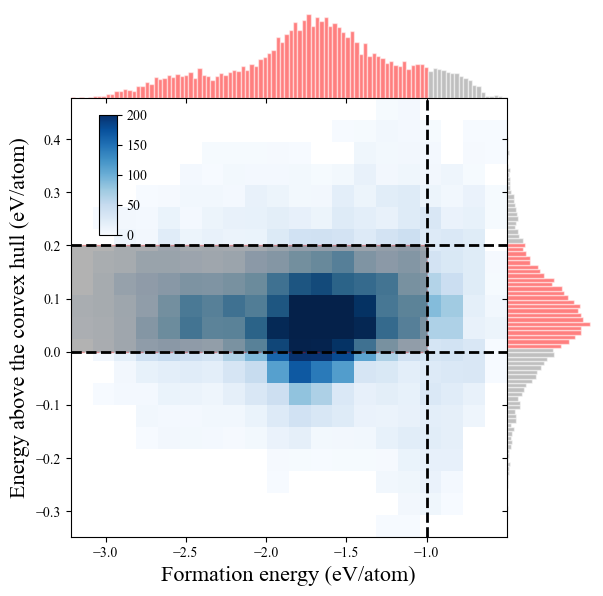

START /bin/eog "/tmp/tmp9wmys_xo.PNG"



(eog:27903): GLib-GIO-CRITICAL **: 11:52:28.472: g_dbus_proxy_new_sync: assertion 'G_IS_DBUS_CONNECTION (connection)' failed

(eog:27903): dconf-WARNING **: 11:52:28.611: failed to commit changes to dconf: Error spawning command line “dbus-launch --autolaunch=4a3a0db9af164246aefc8b9b9d1c490f --binary-syntax --close-stderr”: 子进程退出，代码 1

(eog:27903): dconf-WARNING **: 11:52:28.611: failed to commit changes to dconf: Error spawning command line “dbus-launch --autolaunch=4a3a0db9af164246aefc8b9b9d1c490f --binary-syntax --close-stderr”: 子进程退出，代码 1


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image

plt.rcParams["font.family"] = "Times New Roman"

# Load the data
file_path = '../Data/4_APs_with_Ef_Ehull_prediction_results.csv'
data = pd.read_csv(file_path)

# Extract data for plotting
E_f = data['ensemble_mean']
E_hull = data['e_hull_from_roost']

# Set up the JointGrid
g = sns.JointGrid(x=E_f, y=E_hull, space=0, ratio=5)

# Create 2D histogram on the main axes with updated color range settings for better visibility
counts, xedges, yedges, im = g.ax_joint.hist2d(E_f, E_hull, bins=20, cmap="Blues", cmin=1, vmin=0, vmax=200)  # Adjusted vmin and vmax to enhance visibility

# Add horizontal and vertical lines for reference
g.ax_joint.axvline(x=-1.0, color='k', linestyle='--', linewidth=2)
g.ax_joint.axhline(y=0.0, color='k', linestyle='--', linewidth=2)
g.ax_joint.axhline(y=0.2, color='k', linestyle='--', linewidth=2)

# Add rectangle to emphasize region
rect = patches.Rectangle((-3.3, 0), 2.3, 0.2, linewidth=1, edgecolor='r', facecolor='k', linestyle='--', alpha=0.3)
g.ax_joint.add_patch(rect)

# Create histograms for the marginal plots with colored bins based on conditions
bins = 100

# X Marginal Histogram
n, bins_x, patches_x = g.ax_marg_x.hist(E_f, bins=bins, alpha=0.5, edgecolor='w')
for i in range(len(patches_x)):
    if -3.3 <= bins_x[i] <= -1.0:
        patches_x[i].set_facecolor('red')
    else:
        patches_x[i].set_facecolor('grey')

# Y Marginal Histogram
n, bins_y, patches_y = g.ax_marg_y.hist(E_hull, bins=bins, alpha=0.5, edgecolor='w', orientation='horizontal')
for i in range(len(patches_y)):
    if 0.0 <= bins_y[i] <= 0.2:
        patches_y[i].set_facecolor('red')
    else:
        patches_y[i].set_facecolor('grey')

# Set axis labels
g.set_axis_labels('Formation energy (eV/atom)', 'Energy above the convex hull (eV/atom)', fontsize=16)

# Add color bar with adjusted settings for visibility
cbar_ax = g.fig.add_axes([0.15, 0.60, 0.03, 0.2])
cbar = g.fig.colorbar(im, cax=cbar_ax)

# Save the updated figure
plt.savefig('../Figure/Ef_Ehull_distribution.png')

# Display the saved figure
img = Image.open('../Figure/Ef_Ehull_distribution.png')
img.show()